# Анализ данных о продажах компьютерных игр

## Введение

Интернет магазин, специализирующийся на продаже компьютерных игр, хочет иметь возможность прогнозировать потенциально популярный продукт и планировать относительно него рекламные кампании. Для этого необходимо проанализировать данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Как итог, нужно выявить определяющие успешность игры закономерности. 

<b>План работы:</b>
1. `Подготовка данных`
2. `Исследовательский анализ данных`
3. `Составление портрета пользователя каждого региона`
4. `Проверка гипотез`

Предоставленные данные собраны из открытых источников, 
<br>
они актуальны на `2016` год, необходимо проанализировать их с расчётом на `2017`.

<b>Описание данных</b>
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score`— оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Открытие файлов с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
try:
    data = pd.read_csv('games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')
    
display(data.head(), data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


None

<b>Промежуточный итог:</b>

Видно, что в данных достаточно большое количество пропусков, не совсем корректно именованы столбцы и также некоторые столбцы имеют неверный тип. Всем этим займёмся на следующем этапе. 

## Подготовка данных

Зафиксируем исходный размер датафрейма для последующей проверки. 
<br>
После всех модификаций должно сохраниться как минимум `90%` исходных данных.

In [3]:
data_size_before_modify = data.shape[0]

### Переименование столбцов

In [4]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [5]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков

Для начала посмотрим, какие столбцы содержат пропуски и в каком количестве.

In [6]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Разберёмся со столбцом `name`.

In [7]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Нетрудно заметить, что строки, содержащие пропуски столбце `name` также содержат пропуски в столбцах `genre`. Таких строк всего две, избавимся от них без особых потерь в данных. 
<br>
Отметим возможную причину их появления. Скорее всего, она связана с технической ошибкой, возникшей на одном из этапов создания данных, или с неполными данными в первоисточнике.

In [8]:
data = data.dropna(subset=['name'])
display(data['name'].isna().sum(), data['genre'].isna().sum())

0

0

Также избавимся от строк, содержащих пропуски в столбце `year_of_release`. Пропуски в `year_of_release` не стоит заполнять медианным или средним, поскольку это не имеет особого смысла. Поэтому удаление является оптимальным решением, при этом мы теряем относительно небольшое количество данных.

In [9]:
data = data.dropna(subset=['year_of_release'])
data['year_of_release'].isna().sum()

0

Избавиться от пропусков в `critic_score` путём удаления строк, содержащих их - нелучшее решение. Потеря данных будет значительной (более `6 тыс.` строк).

Проверим, сможем ли мы получить приблизительное значение `critic_score` на основе `user_score` и `rating`.

In [10]:
data[(data['critic_score'].isna()) & (data['user_score'].isna()) & (data['rating'].isna())]['name'].count()

6534

Большее количество пропусков пересекаются, поэтому заполним пропуски медианным значением.

In [11]:
data['critic_score'] = data['critic_score'].fillna(data['critic_score'].median())
data['critic_score'].isna().sum()

0

Возможная причины появления пропусков: неполнота данных в первоисточнике.

Разберёмся с пропусками`user_score`.

In [12]:
data[(~data['user_score'].isna()) & (data['user_score'] != 'tbd')][['critic_score', 'user_score']]

,critic_score,user_score
0,76.0,8
2,82.0,8.3
3,80.0,8
6,89.0,8.5
7,58.0,6.6
...,...,...
16681,71.0,8.1
16692,80.0,7.6
16696,61.0,5.8
16702,60.0,7.2


Попробуем найти приблизительный коэффицент отношения между `critic_score` и `user_score`. Для этого составим вспомогательную таблицу, содержащую строки, у которых нет пропусков в столбце `user_score`, также отбросим строки со значением `tbd`.

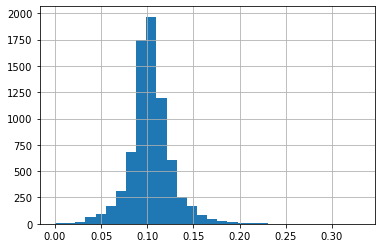

count    7463.000000
mean        0.103226
std         0.022882
min         0.000000
25%         0.092308
50%         0.102439
75%         0.113924
max         0.329630
Name: coeff, dtype: float64

0.532922622816683

In [13]:
valid_user_score_data = (
    data[(data['user_score'] != 'tbd') &  ~(data['user_score'].isna())][['critic_score', 'user_score']]
)
valid_user_score_data['user_score'] = valid_user_score_data['user_score'].astype('float')
valid_user_score_data['coeff'] = valid_user_score_data['user_score'] / valid_user_score_data['critic_score']

valid_user_score_data['coeff'].hist(bins=30)
plt.show()

display(
    valid_user_score_data['coeff'].describe(), 
    valid_user_score_data['user_score'].corr(valid_user_score_data['critic_score'])
)

Большая часть значений в столбце `coeff` лежит в промежуткуе от `0.092308` до `0.113924`. Коэффицент корреляции приблизительно равен `0.53`, значит между `user_score` и `critic_score` средняя связь. Заполним пропуски в `user_score` соответствующими значениями `critic_score`, умноженными на медианное значение столбца `coeff`.

In [14]:
data.loc[data['user_score'].isna(), 'user_score'] = (
    data['critic_score'] * valid_user_score_data['coeff'].median()
)
data['user_score'].isna().sum()

0

Разберёмся со значениями `tbd` в столбце `user_score`. Скорее всего, `tbd` расшифровывается, как `to be determined`, то есть значение на момент сбора данных еще не было определено.

Заменим эти значения на пропуски.

In [15]:
print(f'Значений tbd до заполнения: {data[data["user_score"] == "tbd"].shape[0]}.')
print(f'Пропусков в user_score до заполнения: {data["user_score"].isna().sum()}.')

data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

print(f'Значений tbd после заполнения: {data[data["user_score"] == "tbd"].shape[0]}.')
print(f'Пропусков в user_score после заполнения: {data["user_score"].isna().sum()}.')

Значений tbd до заполнения: 2376.
Пропусков в user_score до заполнения: 0.
Значений tbd после заполнения: 0.
Пропусков в user_score после заполнения: 2376.


In [16]:
data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Пропуски в `rating` оставим. Для удобства заполним их значением `undefined`. Скорее всего они появились, по причине того, что ассоциация ESRB не присвоила этим играм подходящие категории.

In [17]:
data['rating'] = data['rating'].fillna('undefined')
data['rating'].isna().sum()

0

In [18]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score         2376
rating                0
dtype: int64

Все пропуски, которые есть, мы специально создали при работе со значениями `tbd`.

### Изменение типов

In [19]:
display(data.head(), data.dtypes)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,71.0,7.273171,undefined
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,71.0,7.273171,undefined


name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

Приведём столбцы `year_of_release` и `critic_score` к типу `int`, а столбец `user_score` к типу `float`.

In [20]:
data['year_of_release'] = data['year_of_release'].astype('int')
data['critic_score'] = data['critic_score'].astype('int')
data['user_score'] = data['user_score'].astype('float')
data.dtypes

name                object
platform            object
year_of_release      int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score         int64
user_score         float64
rating              object
dtype: object

Добавим в таблицу столбец `total_sales`, содержащий сумму продаж по всем регионам для каждой игры.

In [21]:
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.000000,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,71,7.273171,undefined,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.300000,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.000000,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,71,7.273171,undefined,31.38


### Обработка дубликатов

In [22]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют.

In [23]:
print(f'Текущий размер датафрейма составляет {data.shape[0] / data_size_before_modify:.2%} от исходного.')

Текущий размер датафрейма составляет 98.38% от исходного.


<b>Промежуточный итог:</b> 

Мы привели названия столбцов к нижнему регистру, удалили строки с пропусками в `name`, `genre` и `year_of_release`, заполнили пропуски в `critic_score` медианным значением и пропуски в `user_score` на основании `critic_score`. Также убедились в отсутствии явных дубликатов и заполнили значения `tbd` пропусками.

## Исследовательский анализ данных

Рассмотрим количество выпущенных игр за каждый год. Отметим, что, скорее всего, для нашей задачи не важны сведения за все года, поскольку тенденции периодически меняются, и некоторые данные со временем теряют свою актуальность.

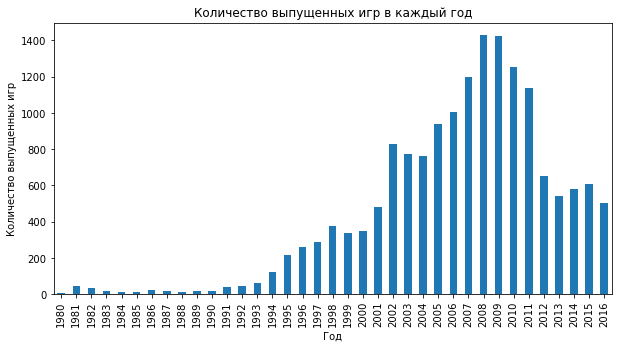

In [24]:
(data.groupby('year_of_release')['name'].count()
    .plot.bar(figsize=(10,5), xlabel='Год', ylabel='Количество выпущенных игр'))
plt.title('Количество выпущенных игр в каждый год')
plt.show()

Наибольшее количество игр вышло в промежуток от `2005` до `2011` года, наименьшее от `1980` до `1992` года.

Теперь найдём `5` платформ с наибольшим числом продаж и для каждой из них построим график изменения продаж в зависимости от года.

In [25]:
high_sales_platforms = data.groupby('platform')['total_sales'].sum().sort_values().tail(5).reset_index()
high_sales_platforms

,platform,total_sales
0,DS,802.78
1,Wii,891.18
2,PS3,931.34
3,X360,961.24
4,PS2,1233.56


Получаем, что наибольшим числом продаж обладают игры для следующих платформ: `DS`, `Wii`, `PS3`, `X360`, `PS2`. Теперь построим для них графики зависимости продаж от года и заодно определим приблизительный период актуальности платформы.

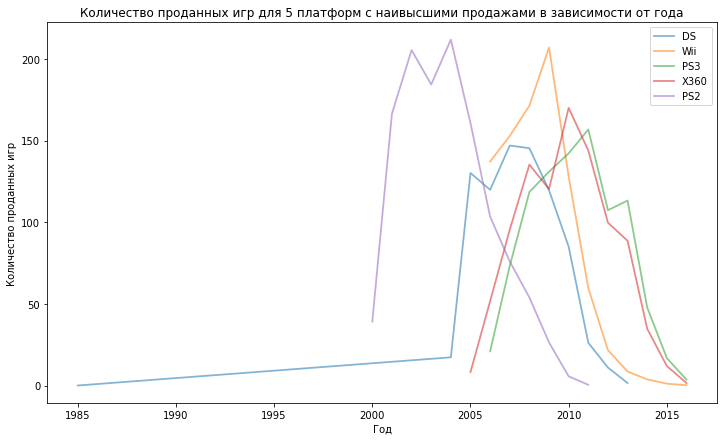

In [26]:
plt.figure(figsize=(12,7))
for platform in high_sales_platforms['platform']:
    plt.plot(
            data[data['platform'] == platform]['year_of_release'].sort_values().unique(), 
            data[data['platform'] == platform].groupby('year_of_release')['total_sales'].sum(),
            alpha=.55,
            label=platform,
            lw=1.8
    )
plt.title('Количество проданных игр для 5 платформ с наивысшими продажами в зависимости от года')
plt.xlabel('Год')
plt.ylabel('Количество проданных игр')
plt.legend()
plt.show()

Найдём приблизительное время "жизни" платформы. То есть за этот срок появляются новые и, возможно, полностью теряют актуальность старые платформы

In [27]:
platforms_periods = data.groupby('platform').agg({'year_of_release': ['min', 'max']})
platforms_periods.columns = ['min', 'max']
print(f'Приблизительное время жизни платформы составляет {(platforms_periods["max"] - platforms_periods["min"]).median()} лет.')

Приблизительное время жизни платформы составляет 6.0 лет.


Будем считать данные актуальными, если они содержат сведения за последние три года. В дальнейшем в работе будем использовать только актуальные данные, а остальные будем считать неактуальными в контексте нашей задачи.

Посчитаем граничное значение.

In [28]:
actual_data = data[data['year_of_release'] >= 2014]
actual_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,71,7.273171,undefined,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.300000,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,71,7.273171,undefined,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.300000,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,71,7.273171,undefined,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,71,7.273171,undefined,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,71,7.273171,undefined,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,71,7.273171,undefined,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,71,7.273171,undefined,0.01


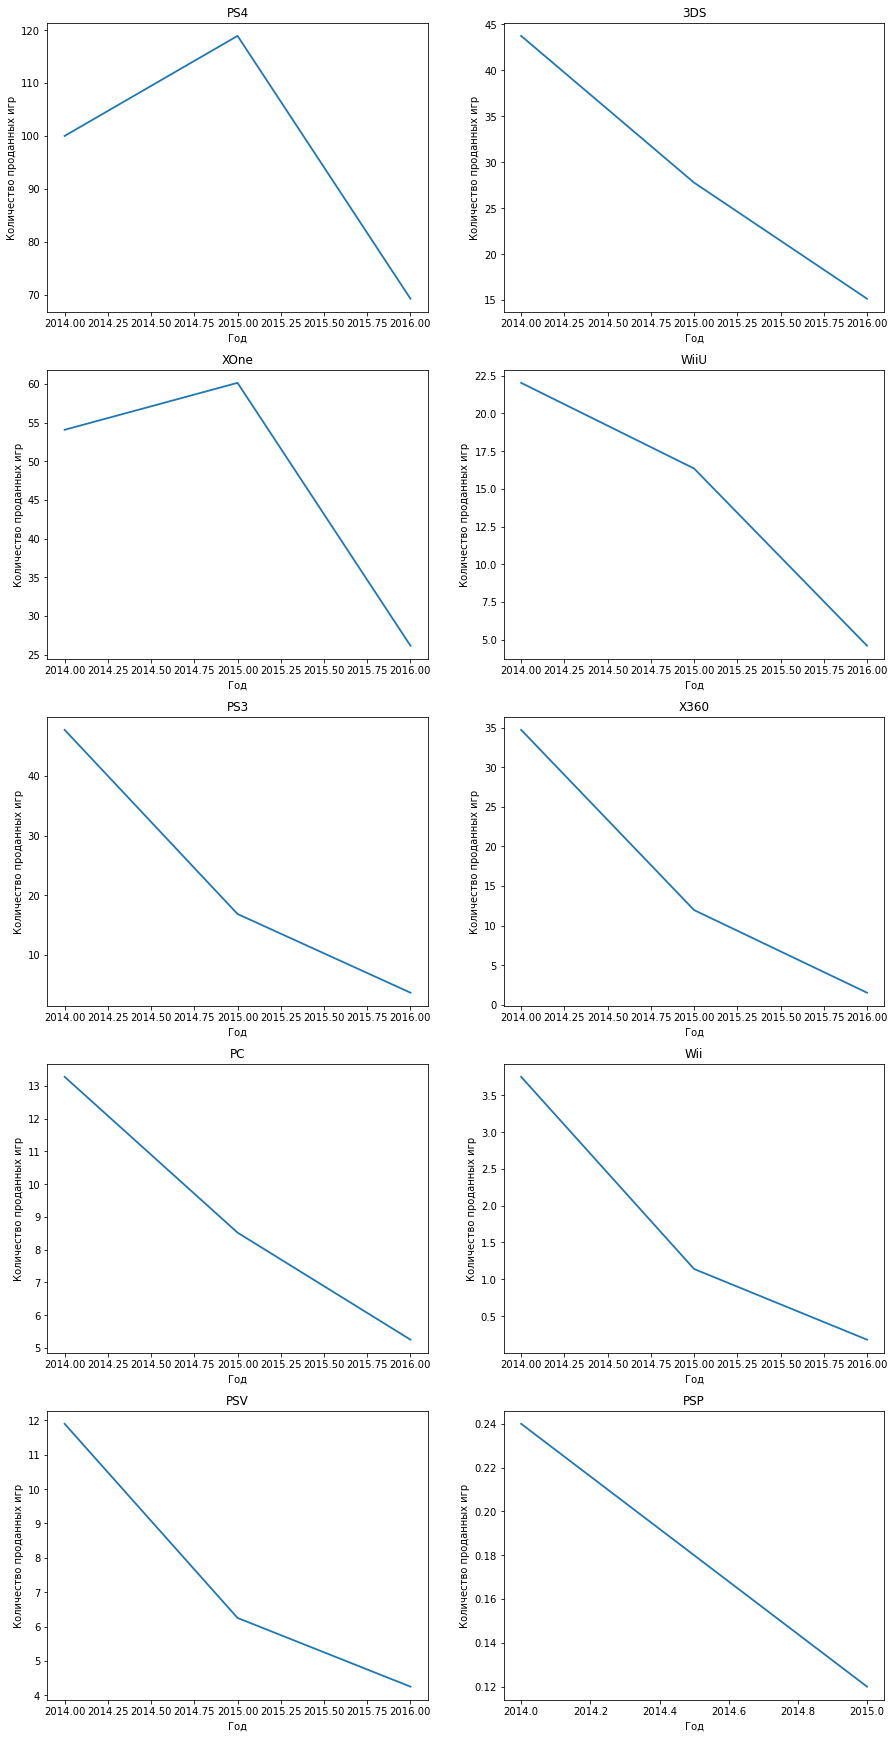

In [29]:
plt.figure(figsize=(15, 50))
idx = 1
for platform in actual_data['platform'].unique():
    plt.subplot(8, 2, idx)
    plt.plot(
            actual_data[actual_data['platform'] == platform]['year_of_release'].sort_values().unique(), 
            actual_data[actual_data['platform'] == platform].groupby('year_of_release')['total_sales'].sum(),
            lw=1.8
    )
    plt.title(platform)
    plt.xlabel('Год')
    plt.ylabel('Количество проданных игр')
    idx += 1
plt.show()

Проанализировав графики, можем сделать следующие выводы: 
* Наиболее перспективными платформами являются следующие: `PS4`, `XOne`,
* Наименее перспективными являются: `X360`, `Wii`, `PSP`, `PS3`.

In [30]:
platforms_total_sales = actual_data.groupby('platform')['total_sales'].sum().sort_values().reset_index()
platforms_total_sales.tail()

,platform,total_sales
5,X360,48.22
6,PS3,68.18
7,3DS,86.68
8,XOne,140.36
9,PS4,288.15


Платформы, лидирующие по продажам (по возрастанию количества продаж): `X360`, `PS3`, `3DS`, `XOne`, `PS4`.

Построим диаграммы размаха для общих продаж каждой из платформ.

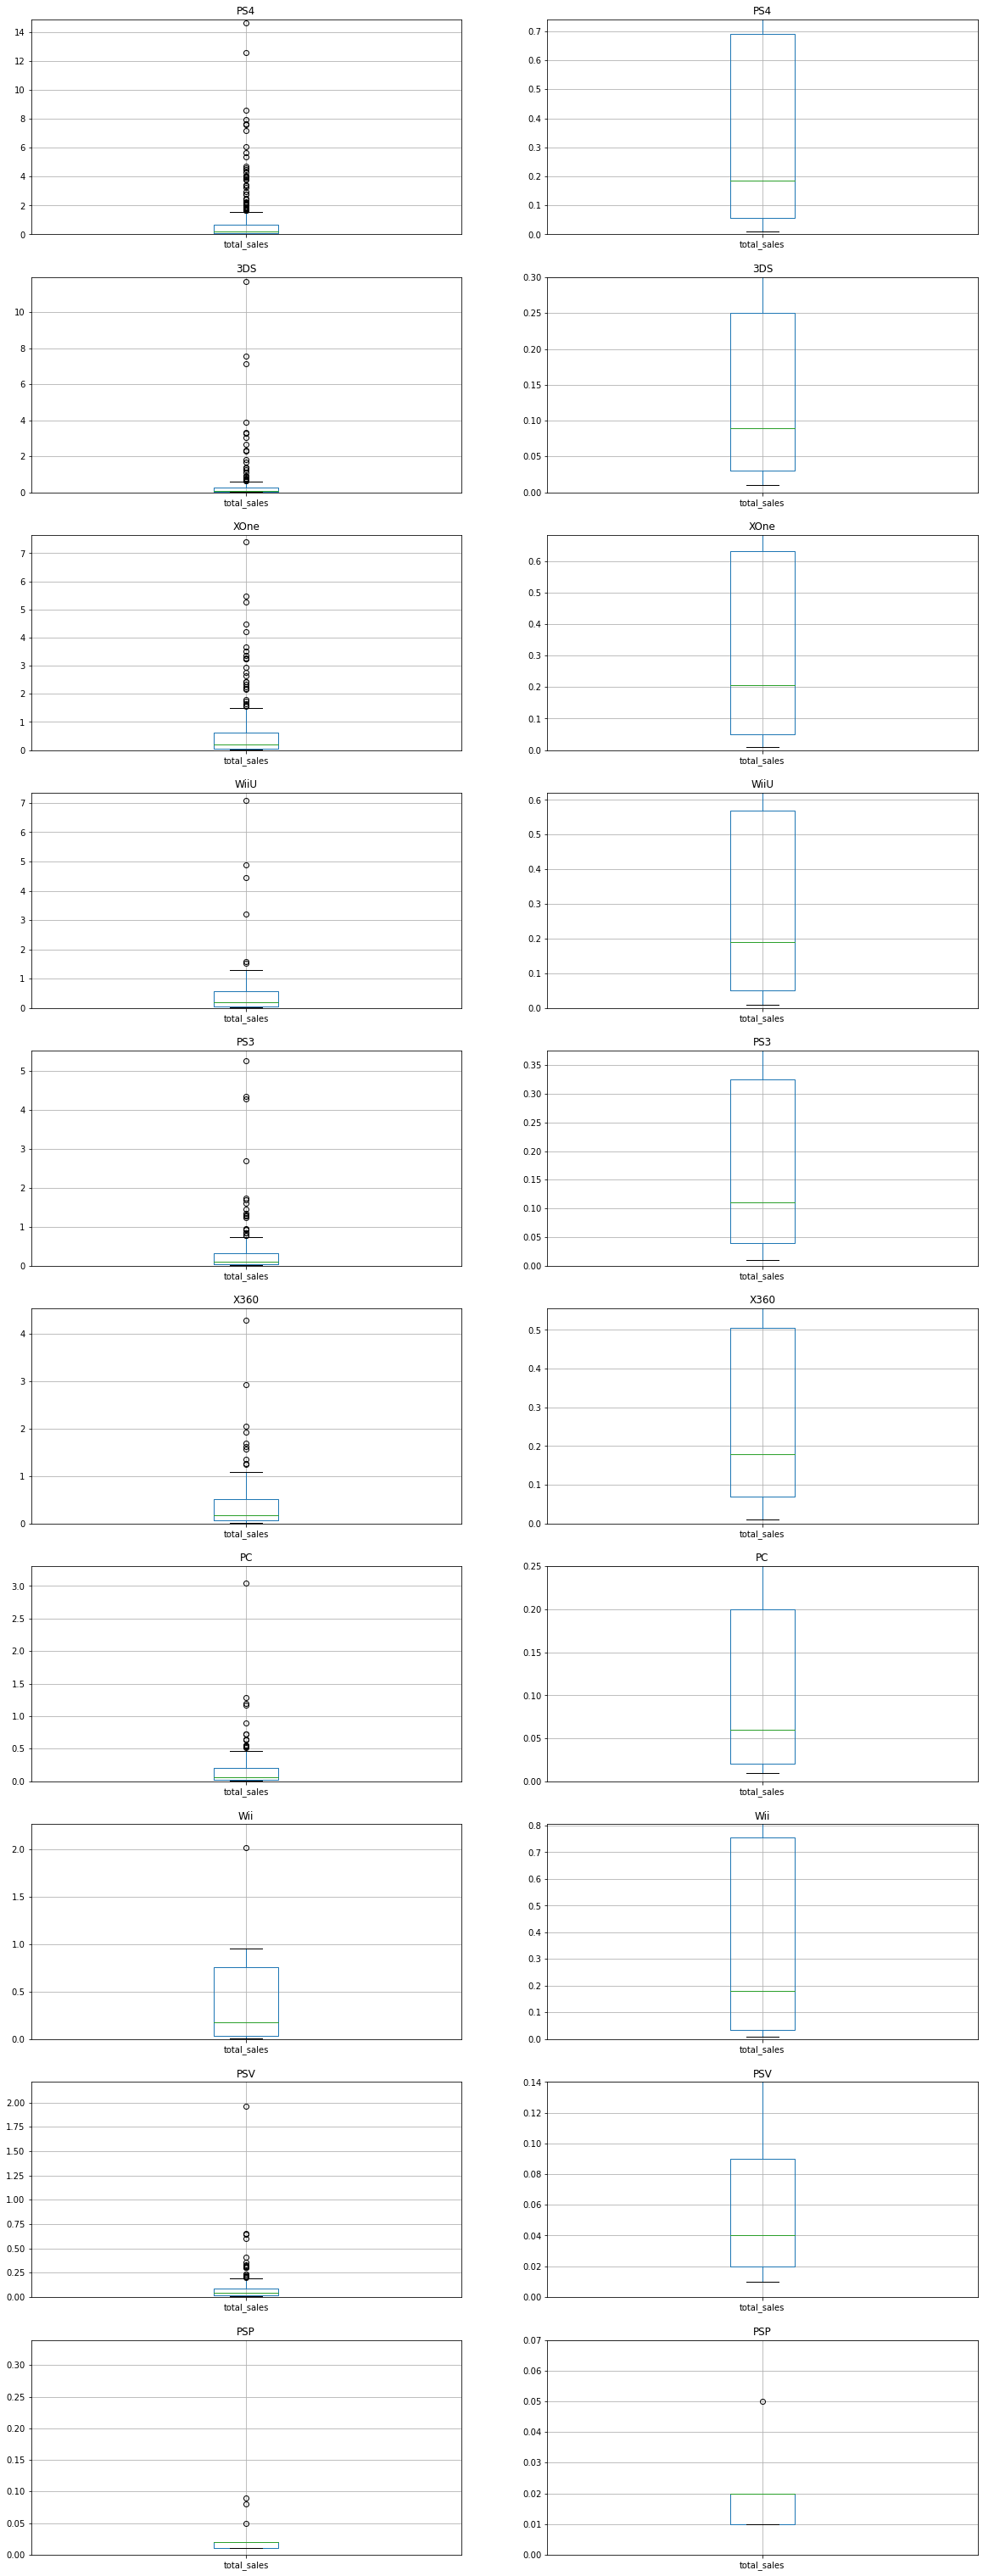

In [31]:
plt.figure(figsize=(20, 55))

for i, platform in enumerate(actual_data['platform'].unique()):
    plt.subplot(10, 2, 2 * i + 1)
    actual_data[actual_data['platform'] == platform].boxplot('total_sales')
    plt.ylim((0, actual_data[actual_data['platform'] == platform]['total_sales'].max() + 0.25))
    plt.title(f'{platform}')
    plt.subplot(10, 2, 2 * i + 2)
    actual_data[actual_data['platform'] == platform].boxplot('total_sales')
    plt.ylim((0, actual_data[actual_data['platform'] == platform]['total_sales'].quantile(0.75) + 0.05))
    plt.title(f'{platform}')
    plt.ylabel('')

Практически во всех случаях мы можем наблюдать некоторое число выбросов. Причём, заметим что выбросов больше у тех платформ, которые более актуальны и имеют больше продаж.

Посмотрим, как влияют на продажи внутри самой 3 наиболее популярных платформ отзывы пользователей и критиков.

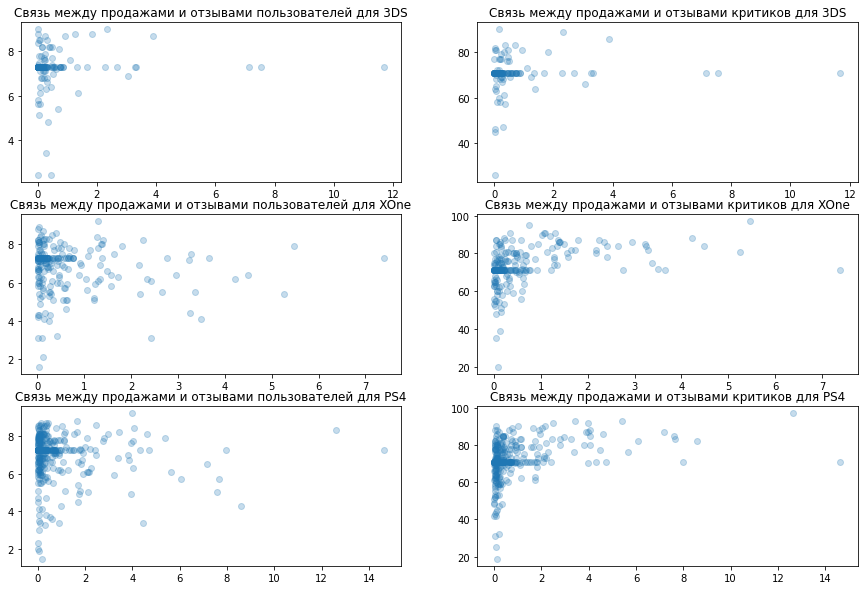

In [32]:
platforms_to_compare = platforms_total_sales.tail(3)['platform'].values

plt.figure(figsize=(15, 10))
for i, platform in enumerate(platforms_to_compare):
    platform_data = actual_data[actual_data['platform'] == platform].dropna()
    plt.subplot(3, 2, 2 * i + 1)
    plt.title(f'Связь между продажами и отзывами пользователей для {platform}')
    plt.scatter(x=platform_data['total_sales'], y=platform_data['user_score'], alpha=.25)
    plt.subplot(3, 2, 2 * i + 2)
    plt.title(f'Связь между продажами и отзывами критиков для {platform}')
    plt.scatter(x=platform_data['total_sales'], y=platform_data['critic_score'], alpha=.25)

По диаграммам видно, что с увеличением оценок критиков увеличивается число продаж. Для отзывов пользователей такой зависимости не наблюдается. Логично предположить, что такая закономерность распространяется не только на рассматриваемые платформы.

Посчитаем коэффиценты корреляции.

In [33]:
platforms_to_cmp_corr = pd.DataFrame()

for platform in platforms_to_compare:
    platform_data = actual_data[actual_data['platform'] == platform].dropna()
    platforms_to_cmp_corr[platform] = [
        platform_data['user_score'].corr(platform_data['total_sales']),
        platform_data['critic_score'].corr(platform_data['total_sales']),
    ]
platforms_to_cmp_corr.index = ['user_score', 'critic_score']
platforms_to_cmp_corr

,3DS,XOne,PS4
user_score,0.066759,-0.078892,-0.052000
critic_score,0.087755,0.369967,0.333486


Получаем примерно тот же результат, который получили при анализе соответствующих графиков. Связь продаж и `user_score` практически отсутвует, а для `XOne` и `PS4`, судя по коэффицентам, продажи и оценки пользователей обратно пропорциональны. Отметим, что связь `critic_score` и `total_sales` для `3DS` значительно меньше, чем для остальных платформ.

Определим самых прибыльные жанры, жанры с высокими и низкими продажами. Интересующие нас жанры найдём, исходя из медиан общих продаж.

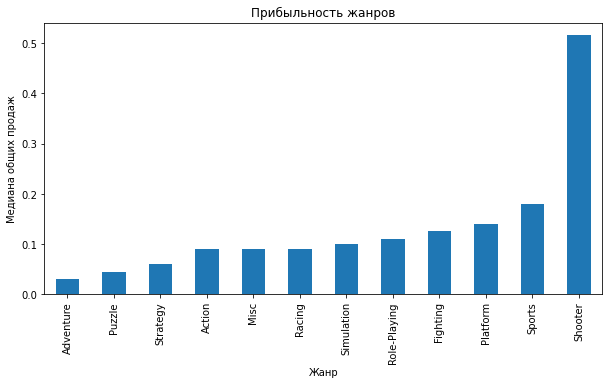

In [34]:
actual_data.groupby('genre')['total_sales'].median().sort_values().plot.bar(
    xlabel='Жанр', 
    ylabel='Медиана общих продаж',
    title='Прибыльность жанров',
    figsize=(10,5)
)
plt.show()

* Самый прибыльный жанр - `Shooter`,
* Жанры с высоким числом продаж - `Sports`, `Platform`, `Fighting`, `Role-Playing`,
* Жанры с низким числом продаж - `Adventure`, `Puzzle`, `Strategy`.

<b>Промежуточный итог:</b>
    
Сведения, полученные из исходных данных:
* Наибольшее количество игр вышло в промежуток от 2005 до 2011 года, наименьшее от 1980 до 1992 года.
* Наибольшим числом продаж обладают игры для следующих платформ: `DS`, `Wii`, `PS3`, `X360`, `PS2`.
* Характерный срок, за который появляются новые и исчезают старые платформы - `6` лет.

Мы определили минимальный год, начиная с которого будем считать данные актуальными - `2014`.
В последствии мы используем только их.

Мы также сделали значимые выводы о направлении изменения числа продаж платформ с течением времени:
* Наиболее перспективными платформами являются следующие: `PS4`, `XOne`,
* Наименее перспективными являются: `X360`, `Wii`, `PSP`, `PS3`.

Платформы, лидирующие по продажам (по возрастанию количества продаж): `X360`, `PS3`, `3DS`, `XOne`, `PS4`.

Далее мы установили, что для некоторых платформ с увеличением оценок критиков увеличивается число продаж и изучили прибыльность разных жанров.

* Самый прибыльный жанр - `Shooter`,
* Жанры с высоким числом продаж - `Sports`, `Platform`, `Fighting`, `Role-Playing`,
* Жанры с низким числом продаж - `Adventure`, `Puzzle`, `Strategy`.

## Портреты пользователей каждого региона

На этом этапе мы составим среднестатистический портрет пользователя каждого региона.
Для каждого региона определим:
* Топ-5 популярные платформы.
* Топ-5 популярных жанры.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Первым делом, для каждого региона найдём `5` самых популярных платформ.

Регион: NA


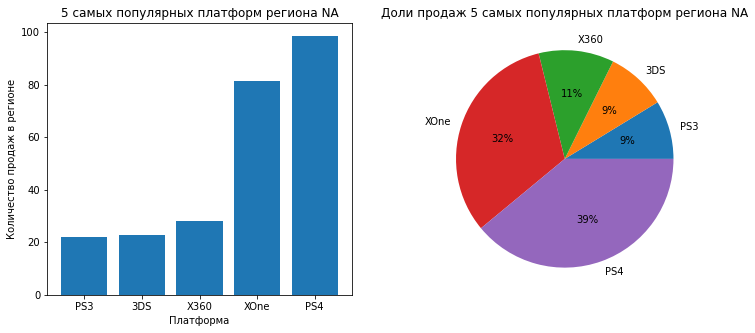

Регион: EU


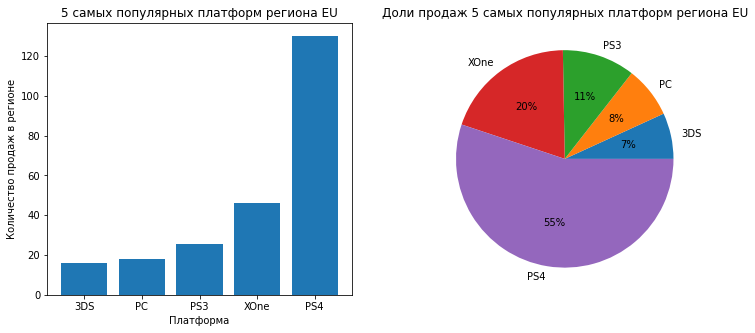

Регион: JP


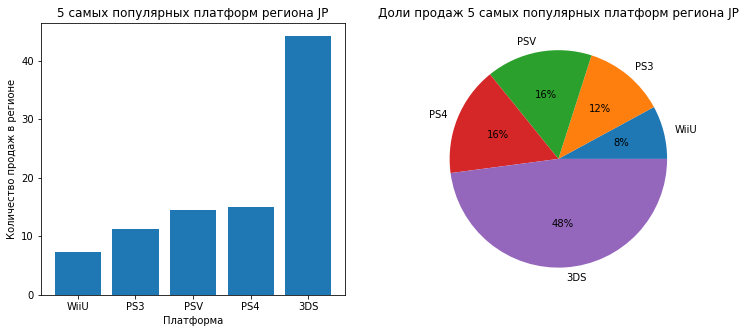

In [35]:
for region in ['NA', 'EU', 'JP']:
    print('Регион:', region)
    column = region.lower()+'_sales'
    top_region_platforms = actual_data.groupby('platform')[column].sum().sort_values().reset_index().tail()
    top_region_platforms[column] = np.round(top_region_platforms[column], 2)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    ax_plot_bar = axes[0]
    ax_plot_bar.bar(top_region_platforms['platform'], top_region_platforms[column])
    ax_plot_bar.set_title(f'5 самых популярных платформ региона {region}')
    ax_plot_bar.set_xlabel('Платформа')
    ax_plot_bar.set_ylabel('Количество продаж в регионе')
    
    ax_plot_pie = axes[1]
    ax_plot_pie.pie(top_region_platforms[column], labels=top_region_platforms['platform'], autopct='%1.f%%')
    ax_plot_pie.set_title(f'Доли продаж 5 самых популярных платформ региона {region}')
    
    plt.show()

Проанализируем графики.
<br>
<br>
Для региона `NA` получаем следующее: 
* Пять самых популярных платформ (по возрастанию количества продаж) - `PS3`, `3DS`, `X360`, `XOne`, `PS4`.
* Соответствующие доли продаж: `9%`, `9%`, `11%`, `32%`, `39%`.

Для региона `EU`:
* Пять самых популярных платформ (по возрастанию количества продаж) - `3DS`, `PC`, `PS3`, `XOne`, `PS4`.
* Соответствующие доли продаж: `7%`, `8%`, `11%`, `20%`, `55%`.

Наконец, для `JP`:
* Пять самых популярных платформ (по возрастанию количества продаж) - `WiiU`, `PS3`, `PSV`, `PS4`, `3DS`.
* Соответствующие доли продаж: `8%`, `12%`, `16%`, `16%`, `48%`.

В регионах `NA`и `EU` ситуации имеют некоторые сходства, в отличие от `JP`, сведения о котором заметно отличаются. Это касается и наборов платформ, и распределений долей продаж для этих платформ. 

Теперь найдём по `5` самых популярных жанров для каждого региона.

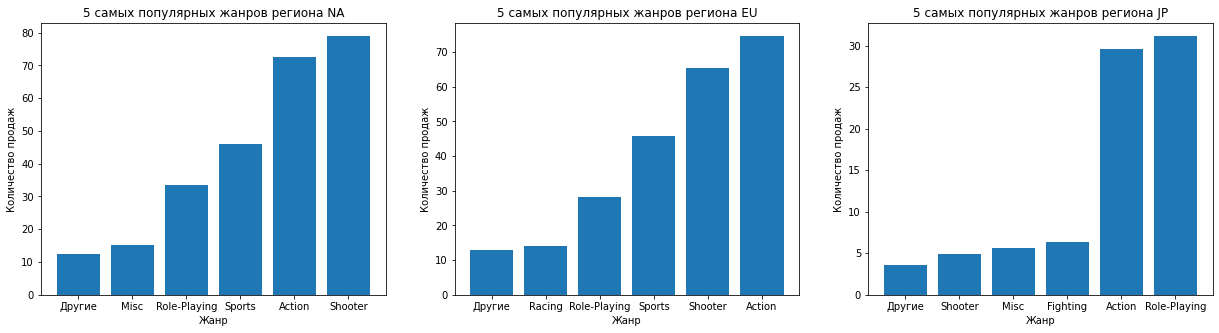

In [36]:
plt.figure(figsize=(21, 5))

for i, region in enumerate(['NA', 'EU', 'JP']):
    column = region.lower() + '_sales'
    top_region_genres = (
        actual_data
            .groupby('genre')[column]
            .sum()
            .sort_values()
            .reset_index()
            .tail()
    )
    another_region_genres = (
        actual_data
            .groupby('genre')[column]
            .sum()
            .sort_values()
            .reset_index()
            .iloc[0:-5]
    )
    another_region_genres['genre'] = 'Другие'
    top_region_genres = top_region_genres.merge(another_region_genres, how='outer').sort_values(by=column)
    
    plt.subplot(1, 3, i + 1)
    plt.bar(top_region_genres['genre'], top_region_genres[column])
    plt.title(f'5 самых популярных жанров региона {region}')
    plt.xlabel('Жанр')
    plt.ylabel('Количество продаж')

5 самых популярных жанров для региона `NA` (по возрастанию количества продаж): `Misc`, `Role-Playing`, `Sports`, `Action`, `Shooter`.
<br>
Для `EU`: `Racing`, `Role-Playing`, `Sports`, `Shooter`, `Action`.
<br>
В `JP` `5` наиболее популярных жанров следующие: `Shooter`, `Misc`, `Fighting`, `Action`, `Role-Playing` (по возрастанию количества продаж).
<br>
Для жанров также прослеживается тенденции сходства `NA` с `EU` и их различия с `JP`.

Посмотрим, как в разных регионах рейтинг `ESRB` влияет на число продаж.

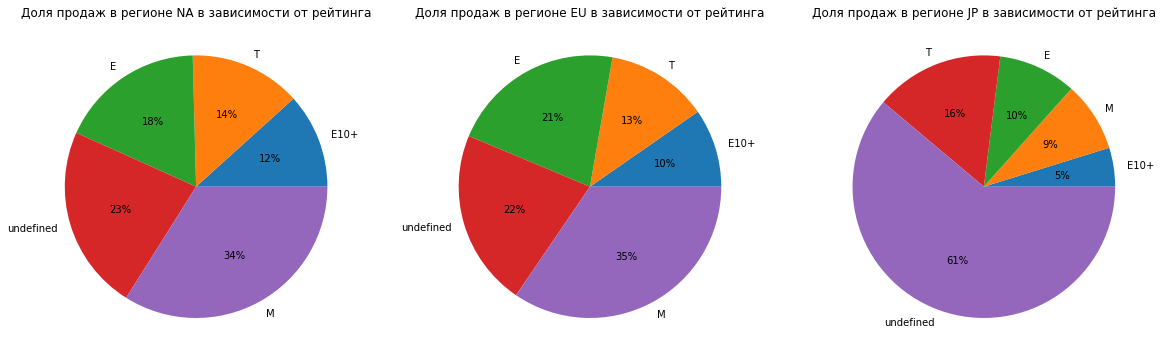

In [37]:
plt.figure(figsize=(20,10))

for i, region in enumerate(['NA', 'EU', 'JP']):
    column = region.lower() + '_sales'
    region_sales = actual_data.groupby('rating')[column].sum().reset_index().sort_values(by=column)
    
    plt.subplot(1, 3, i + 1)
    plt.pie(region_sales[column], autopct='%1.f%%', labels=region_sales['rating'])
    plt.title(f'Доля продаж в регионе {region} в зависимости от рейтинга')

Зависимость между рейтингом `ESRB` и количеством продаж есть. Игры с рейтингом `E10+` наименее популярны.
В регионе `NA` наибольшее число продаж имеют игры с рейтингом `M`, в `EU` также `M`. В регионе `JP` наибольшее число продаж имеют игры, чей рейтинг нам неизвестен, но если мы опустим эти значения, то получим, что наибольшее количество продаж свойственно рейтингу `T`.

<b>Промежуточный итог:</b>

Объединим полученные выше сведения для описания портрета среднего пользователя каждого региона.

Для региона `NA` средний пользователь это человек, использующий для игры платформу `PS4` и предпочитающий жанры `Shooter` и `Action`.
Средний пользователь в `EU` также использует платформу `PS4` и является любителем игр жанров `Shooter`, `Action`.
Пользователь в `JP`, вероятнее всего, выбрал бы платформу `3DS` и предпочёл бы игры жанров `Role-Playing` или `Action`.

In [38]:
average_users = pd.DataFrame({
    'region': ['NA', 'EU', 'JP'],
    'platform': ['PS4', 'PS4', '3DS'],
    'genres': ['Shooter, Action', 'Shooter, Action', 'Role-Playing, Action']
})

average_users

,region,platform,genres
0,NA,PS4,"Shooter, Action"
1,EU,PS4,"Shooter, Action"
2,JP,3DS,"Role-Playing, Action"


Также мы установили зависимость между рейтингом ESRB и количеством продаж в регионе. Зависимость между рейтингом `ESRB` и количеством продаж есть. Игры с рейтингом `M` или `T` имеют наибольшее число продаж, а для рейтинга `E10+`, наоборот, характерно низкое число продаж.

## Проверка гипотез

Проверим следующие гипотезы:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Пороговое значение стат. значимости положим равным `0.05`. Проверим гипотезы `t-тестом`. В обоих случаях применим метод `ttest_ind` для независимых выборок из модуля `scipy.stats`.

Сформулируем нулевую гипотезу `H0` и альтернативную гипотезу `H1` для первого теста:
<br>
`H0` - Средние пользовательские рейтинги платформ `Xbox One` и `PC` равны,
<br>
`H1` - Средние пользовательские рейтинги платформ `Xbox One` и `PC` не равны.

In [39]:
alpha = .05

text_success = 'Нет статистически значимой разницы: не отвергаем нулевую гипотезу.'
text_fail = 'Есть статистически значимая разница: отвергаем нулевую гипотезу в пользу альтернативной.'

res = st.ttest_ind(
    actual_data[actual_data['platform'] == 'XOne']['user_score'].dropna(), 
    actual_data[actual_data['platform'] == 'PC']['user_score'].dropna()
)

print(f'p-value: {res.pvalue}')
print(f'Среднее значение для XOne: {actual_data[actual_data["platform"] == "XOne"]["user_score"].mean()}')
print(f'Среднее значение для PC: {actual_data[actual_data["platform"] == "PC"]["user_score"].mean()}')

if res.pvalue < alpha:
    print(text_fail)
else:
    print(text_success)

p-value: 0.04610097158965101
Среднее значение для XOne: 6.754332921209389
Среднее значение для PC: 6.456498496491811
Есть статистически значимая разница: отвергаем нулевую гипотезу в пользу альтернативной.


По результатам теста, гипотеза "средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые" НЕ подтвердилась.

Сформулируем нулевую гипотезу `H0` и альтернативную гипотезу `H1` для второго теста:
<br>
`H0` - Средние пользовательские рейтинги жанров `Action` и `Sports` равны,
<br>
`H1` - Средние пользовательские рейтинги жанров `Action` и `Sports` не равны.

In [40]:
res = st.ttest_ind(
    actual_data[actual_data['genre'] == 'Action']['user_score'].dropna(), 
    actual_data[actual_data['genre'] == 'Sports']['user_score'].dropna()
)

print(f'p-value: {res.pvalue}')
print(f'Среднее значение для Action: {actual_data[actual_data["genre"] == "Action"]["user_score"].mean()}')
print(f'Среднее значение для Sports: {actual_data[actual_data["genre"] == "Sports"]["user_score"].mean()}')

if res.pvalue < alpha:
    print(text_fail)
else:
    print(text_success)

p-value: 2.4170797603660164e-34
Среднее значение для Action: 7.009718185264818
Среднее значение для Sports: 5.550702632854139
Есть статистически значимая разница: отвергаем нулевую гипотезу в пользу альтернативной.


Отвергаем нулевую гипотезу, следовательно, признаем альтернативую гипотезу верной. Значит, исходная гипотеза "средние пользовательские рейтинги жанров `Action` и `Sports` разные" подтвердилась.

<b>Промежуточный итог:</b> 

Мы проверили две гипотезы, проведя `t-тесты`, в результате которых гипотеза "средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые" оказалась неверной, а гипотеза "средние пользовательские рейтинги жанров `Action` и `Sports` разные" верной.

# Итоговый вывод

Главное целью нашего исследования было выявление факторов, определяющих успех игры.

Тезисно опишем промежуточные выводы, полученные в ходе нашего исследования.

<b>Первым делом из сводной информации мы установили наличие следующих проблемы в данных:</b>
* В данных достаточно большое количество пропусков,
* Не совсем корректно именованы столбцы,
* Некоторые столбцы имеют неверный тип.

<b>На следующем этапе мы занимались `предобработкой данных`, непосредственно устранением обнаруженных проблем:</b>
* Привели названия столбцов к нижнему регистру,
* Удалили строки с пропусками в `name`, `genre` и `year_of_release`,
* Заполнили пропуски в `critic_score` медианным значением,
* Заполнили пропуски в `user_score` на основании `critic_score`, 
* Заполнили значения `tbd` столбца `user_score` пропусками (значениями `NaN`).
* Убедились в отсутствии явных дубликатов.

В результате всех модификаций мы потеряли всего `1.62%` исходных данных.

<b>На `3` этапе мы провели `исследовательский анализ`, в результате которого разделили данные на `актуальные`-`неактуальные` и получили важные сведения:</b>

Выводы, полученные из исходных данных:
* Наибольшее количество игр вышло в промежуток от `2005` до `2011` года, наименьшее от `1980` до `1992` года.
* Наибольшим числом продаж обладают игры для следующих платформ: `DS`, `Wii`, `PS3`, `X360`, `PS2`.
* Характерный срок, за который появляются новые и исчезают старые платформы - `6` лет.

Мы определили минимальный год, начиная с которого данные считаются актуальными - `2014`. В последствии мы используем только их.

Выводы о направлении изменения числа продаж платформ с течением времени:
* Наиболее перспективными платформами являются следующие: `PS4`, `XOne`,
* Наименее перспективными являются: `X360`, `Wii`, `PSP`, `PS3`.
* Платформы, лидирующие по продажам (по возрастанию количества продаж): `X360`, `PS3`, `3DS`, `XOne`, `PS4`.

 Отметим, что игры для платформ `PS4` и `XOne` достаточно зависимы от оценок критиков (зависимость - `прямая`). Коэффиценты корреляции больше `30%` для обеих платформ.

Прибыльность разных жанров:
* Самый прибыльный жанр - `Shooter`,
* Жанры с высоким числом продаж - `Sports`, `Platform`, `Fighting`, `Role-Playing`,
* Жанры с низким числом продаж - `Adventure`, `Puzzle`, `Strategy`.

<b>Следующий этап был посвящён `составлению портрета среднестатистического пользователя для каждого региона`:</b> 
* Для региона `NA` средний пользователь это человек, использующий для игры платформу `PS4`(доля продаж - `39%`) и предпочитающий жанры `Shooter` и `Action`.
* Средний пользователь в `EU` также использует платформу `PS4`(доля продаж - `55%`) и является любителем игр жанров `Shooter`, `Action`. 
* Пользователь в `JP`, вероятнее всего, выбрал бы платформу `3DS`(доля продаж - `48%`) и предпочёл бы игры жанров `Role-Playing` или `Action`.

Также мы установили зависимость между рейтингом `ESRB` и количеством продаж в регионе. Зависимость между рейтингом `ESRB` и количеством продаж есть. Игры с рейтингом `M` или `T` имеют наибольшее число продаж, а для рейтинга `E10+`, наоборот, характерно низкое число продаж.

<b>На последнем этапе мы занимались `проверкой двух гипотез`:</b>
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action и Sports разные.

В результате мы пришли к выводу, что первая гипотеза является неверной, а вторая верной.

Используем все эти сведения для ответа на вопрос задачи.

<b>Факторы влиящие на успех игры:</b>
1. Актуальность платформы 
2. Жанр
3. Оценки игры от критиков
4. Полученный рейтинг `ESRB`.

Влияние `жанра`, `актуальности платформы`, `рейтинга ESRB` сильно зависит от региона, в то время, как влияние `оценки критиков` зависит от конкретной платформы для которой выпускается игра.